In [8]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack  # For combining sparse matrices

# Load the dataset
df = pd.read_csv('../data/bird/tablenames_dataset.csv')

# Preprocess the dataset
df['input_text'] = df['db_id'] + " " + df['question'] + " " + df['evidence']
df['primary_table'] = df['table_names'].apply(lambda x: eval(x)[0] if eval(x) else None)

# Drop rows with missing input_text or primary_table values
df_cleaned = df.dropna(subset=['input_text', 'primary_table'])

# Prepare features and target
X_text = df_cleaned['input_text']
X_db = pd.get_dummies(df_cleaned['db_id'], sparse=True)  # One-hot encode db_id
y = df_cleaned['primary_table']

# Train-test split
X_text_train, X_text_test, X_db_train, X_db_test, y_train, y_test = train_test_split(
    X_text, X_db, y, test_size=0.2, random_state=42
)

# Vectorize text input
vectorizer = TfidfVectorizer(max_features=5000)
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(X_text_test)

# Combine TF-IDF features with db_id encoding
X_train_combined = hstack([X_text_train_vec, X_db_train])
X_test_combined = hstack([X_text_test_vec, X_db_test])

# Define baseline models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "NaiveBayes": MultinomialNB()
}

# Evaluate each model
baseline_results = {}
y_preds = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_combined, y_train)
    # Predict on test set
    y_pred = model.predict(X_test_combined)
    y_preds[name] = y_pred
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    baseline_results[name] = {
        "Overall Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Macro Avg)": report["macro avg"]["precision"],
        "Recall (Macro Avg)": report["macro avg"]["recall"],
        "F1 Score (Macro Avg)": report["macro avg"]["f1-score"]
    }

# Display results
results_df = pd.DataFrame(baseline_results).T
print(results_df)

                    Overall Accuracy  Precision (Macro Avg)  \
RandomForest                0.761733               0.497755   
LogisticRegression          0.722022               0.443354   
NaiveBayes                  0.628159               0.206386   

                    Recall (Macro Avg)  F1 Score (Macro Avg)  
RandomForest                  0.527802              0.488209  
LogisticRegression            0.452007              0.411678  
NaiveBayes                    0.290850              0.236403  


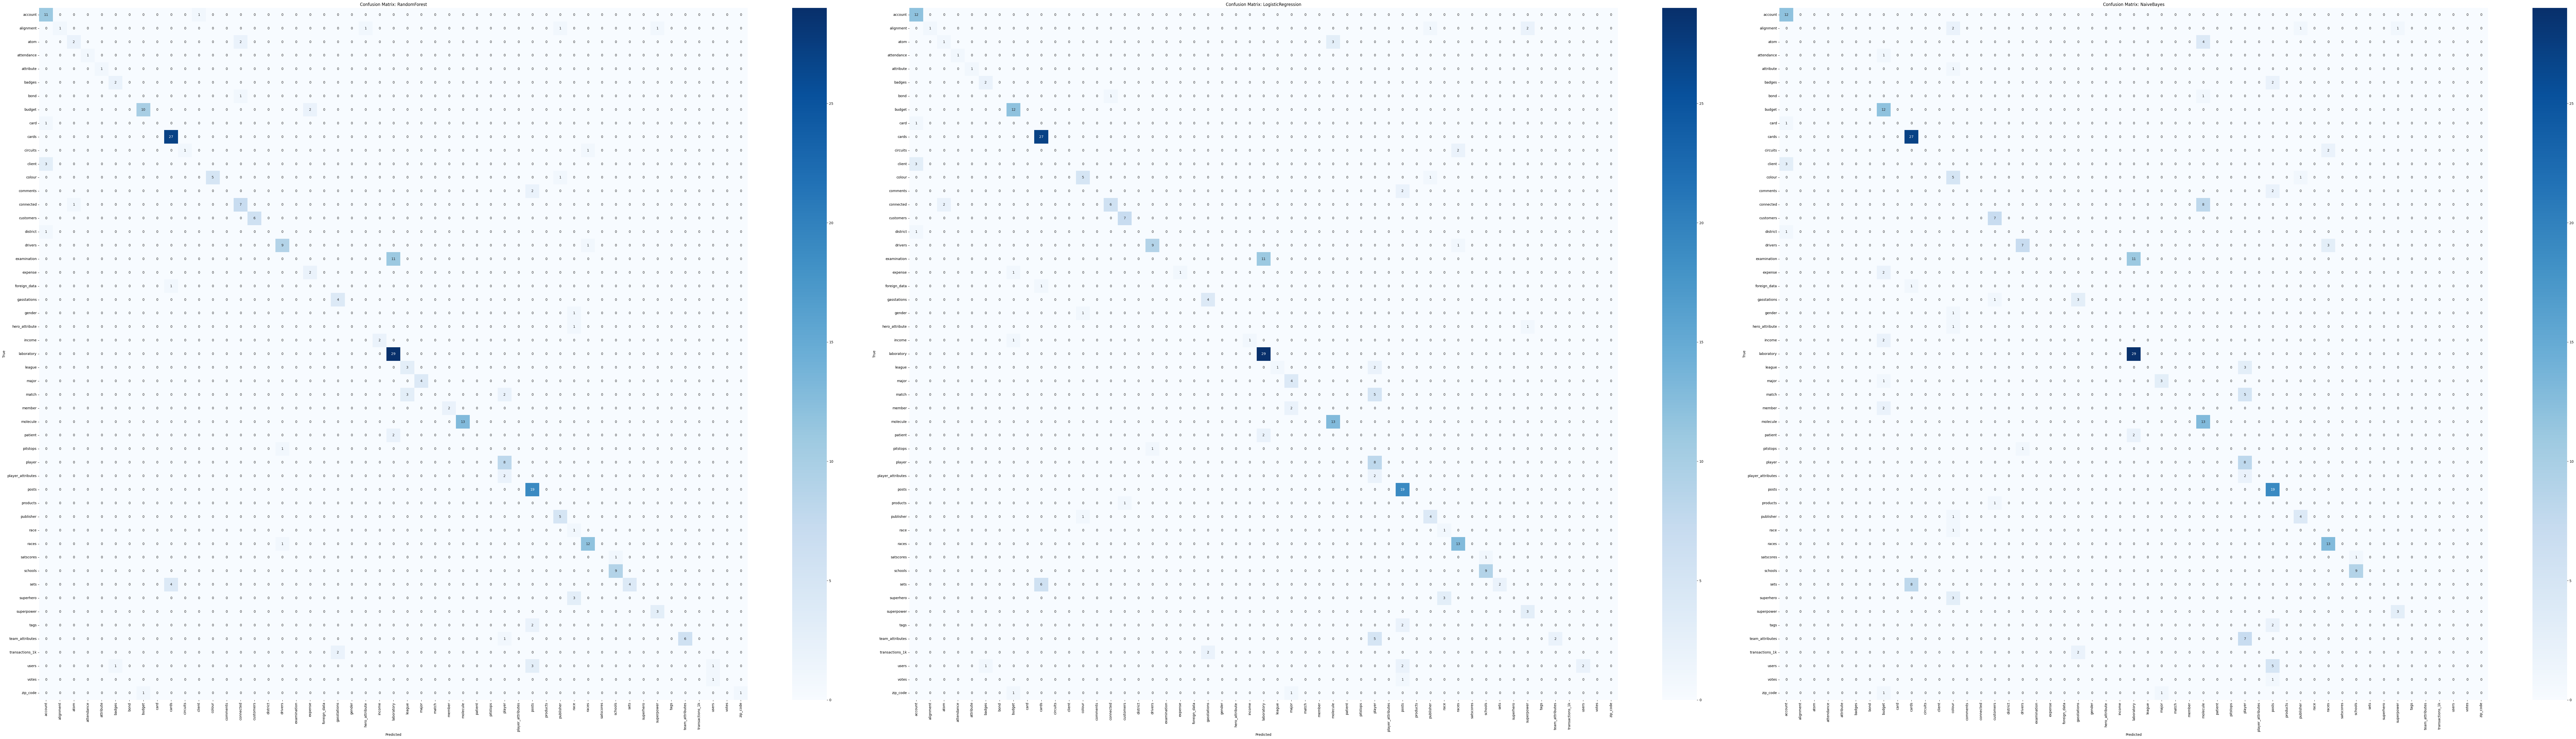

/var/folders/xm/r04ddcwd1rq0h5gtd4gjlmqw0000gn/T/ipykernel_24413/3024411171.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Overall Accuracy", data=results_df, palette="viridis")


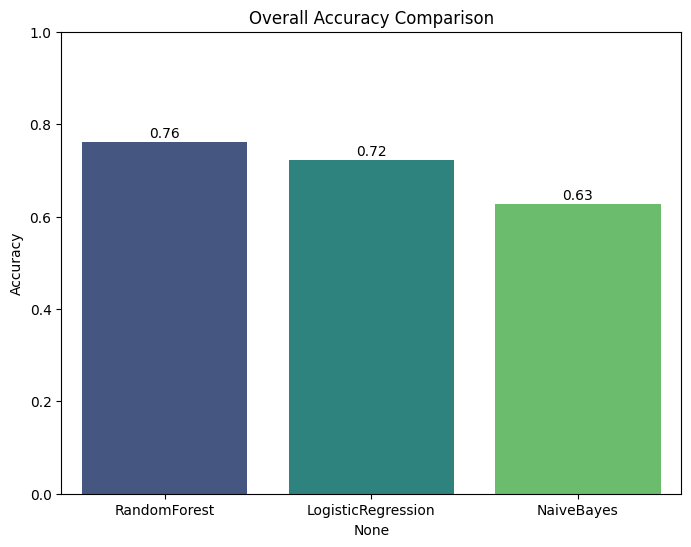

/var/folders/xm/r04ddcwd1rq0h5gtd4gjlmqw0000gn/T/ipykernel_24413/3024411171.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="magma")


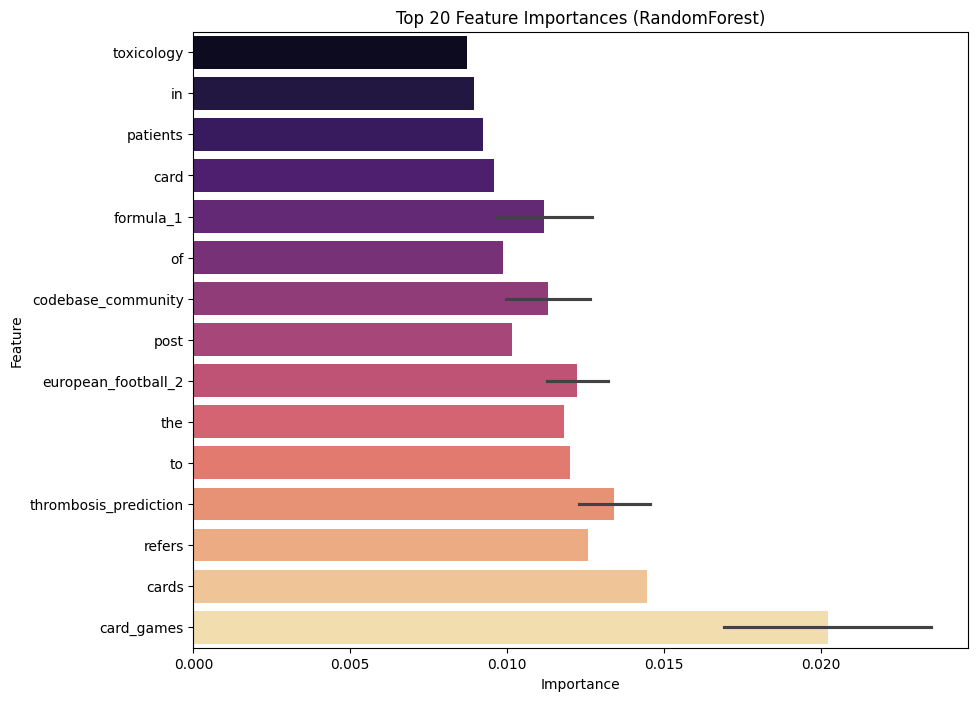

Skipping LogisticRegression coefficients plot (not binary classification or no coef_).


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Confusion Matrices for each model
# Get the unique labels from y_test for consistent labeling
labels = np.unique(y_test)

fig, axes = plt.subplots(1, len(models), figsize=(36 * len(models), 30))
if len(models) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, (name, y_pred) in zip(axes, y_preds.items()):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

# 2. Bar plot of overall accuracy
plt.figure(figsize=(8, 6))
sns.barplot(x=results_df.index, y="Overall Accuracy", data=results_df, palette="viridis")
plt.title("Overall Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(results_df["Overall Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()

# 3. Feature Importance Plot (for RandomForest, if needed)
if "RandomForest" in models:
    rf_model = models["RandomForest"]
    # Get feature names (TF-IDF features + db_id dummy features)
    tfidf_feature_names = vectorizer.get_feature_names_out()
    db_features = X_db.columns
    all_features = np.concatenate([tfidf_feature_names, db_features])

    importances = rf_model.feature_importances_
    # Get top 20 features by importance
    idxs = np.argsort(importances)[-20:]
    top_features = all_features[idxs]
    top_importances = importances[idxs]

    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_importances, y=top_features, palette="magma")
    plt.title("Top 20 Feature Importances (RandomForest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 4. Coefficients Plot for LogisticRegression (optional)
if "LogisticRegression" in models:
    lr_model = models["LogisticRegression"]
    if hasattr(lr_model, 'coef_') and len(labels) == 2:
        # For binary classification logistic regression, we can plot coefficients
        coefs = lr_model.coef_[0]
        # Similar to random forest, get top 20 by absolute value of coefficients
        idxs = np.argsort(np.abs(coefs))[-20:]
        top_features = all_features[idxs]
        top_coefs = coefs[idxs]

        plt.figure(figsize=(10, 8))
        colors = ['red' if c < 0 else 'green' for c in top_coefs]
        sns.barplot(x=top_coefs, y=top_features, palette=colors)
        plt.title("Top 20 Coefficients (LogisticRegression)")
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.show()
    else:
        print("Skipping LogisticRegression coefficients plot (not binary classification or no coef_).")